# Calculating p-values for comparing means between groups

This notebook provides a simple example of how to compare the means of two different groups of data to determine if a difference in means between the groups is statistically significant.  There are multiple statistical tests to do so - we will explore two: ANOVA and the t-test. 

To illustrate how this works, we are going to compare the mean performance of CPUs developed by IBM vs those developed by NAS.  The data comes from the UCI Machine Learning Repository: https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [1]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

import warnings
warnings.filterwarnings("ignore")

# Dictionary of file names and download links
files = {'machine.data':'https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
# Read in the dataset
data = pd.read_csv('machine.data',names=['Vendor','Model','MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP','ERP'])
data.head()

,Vendor,Model,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132


In [4]:
# Take a subset for our analysis including only IBM and NAS hardware
data_anova = data.loc[(data['Vendor']=='ibm') | (data['Vendor']=='nas'),['Vendor','ERP']]
data_anova.rename(mapper={'ERP':'Performance'},axis=1,inplace=True)

## Visualization

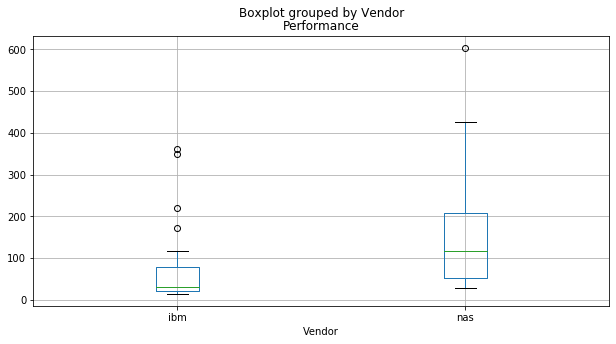

In [5]:
# Visualize the data using a boxplot
#plt.figure(figsize=(10,5))
data_anova.boxplot(column='Performance',by='Vendor',figsize=(10,5))
plt.show()

Based on the above boxplot, it appears that on average NAS's hardware has higher performance rating than IBM. 

In [28]:
# Calculate the mean of each vendor's performance
ibm_mean = data_anova.loc[data_anova['Vendor']=='ibm','Performance'].mean()
nas_mean = data_anova.loc[data_anova['Vendor']=='nas','Performance'].mean()
print('IBM mean: {:.2f}, NAS mean: {:.2f}'.format(ibm_mean,nas_mean))

IBM mean: 71.78, NAS mean: 159.11


However, to determine if the difference in means is statistically significant, we need to use a statistical test.  We will look at how to apply two tests: the ANOVA and the t-test.  ANOVA can be used for more than 2 groups, whereas the t-test is limited to two groups.  When used on only two groups, both tests produce equivalent results.

## T-test
We can use a t-test to determine whether the difference in means between the two vendors is significant.  The null hypothesis in this case is that the means of both groups are equal.  Our goal is then to determine if we accept this null hypothesis. Generally we use a significance level (also called alpha level) of 0.05, meaning that if the p-value of our test is below 0.05, we reject the null hypothesis.  The intuition behind this is that we expect the difference in means to be 0 if the null hypothesis were true.  If the difference in means falls outside of the 95% confidence interval around 0 (corresponding to alpha=0.05), there is a <5% probability that the actual difference would have occured if the null hypothesis were true (there is always some small probability of a non-zero difference even if the null hypothesis were true due to randomness).  Since the probability is less than our alpha value threshold, we reject the null hypothesis

In [6]:
# Run a t-test on the data
from scipy.stats import ttest_ind

cat_1 = data_anova[data_anova['Vendor']=='ibm']
cat_2 = data_anova[data_anova['Vendor']=='nas']

ttest_ind(cat_1['Performance'],cat_2['Performance'],alternative='two-sided')

Ttest_indResult(statistic=-2.6329289016068893, pvalue=0.01129256329093324)

## ANOVA 

ANOVA is a statistical technique used to determine whether there is a statistically significant difference between the means of multiple groups.

In [12]:
# Run an ANOVA analysis
aov_model = ols('Performance ~ Vendor',data=data_anova).fit()
aov_table = sm.stats.anova_lm(aov_model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Vendor,1.0,90907.722168,90907.722168,6.932315,0.011293
Residual,49.0,642567.258224,13113.617515,NaN,NaN


Since our p-value from the above ANOVA table is 0.011 which is less than 0.05, we reject the null hypothesis that the means are equal and thus we determine that the difference in the mean performance between IBM hardware and NAS hardware is in fact statistically significant.

As you can see above, both statistical tests yield the equivalent p-value for two groups, which is lower than our threshold of 0.05 so we reject the null hypothesis that the means are equal.